In [102]:
import this

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
from scipy.signal import savgol_filter
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage

# Fonctions utilisées dans ce projet

In [104]:
## Appliquons la snv à notre array intensities et visualisons 
def snv_spectrum(spectrum):
    mean = np.mean(spectrum)  # Calcul de la moyenne du spectre
    std_dev = np.std(spectrum)  # Calcul de l'écart type du spectre
    snv_spectrum = (spectrum - mean) / std_dev  # Transformation SNV
    return snv_spectrum

def plot_acp_individuals(score, plan_indices, individual_names, class_labels, explained_variance):
    """
    Affiche la carte factorielle des individus d'une ACP.

    Args:
        score (array): Les scores (coordonnées des individus) de l'ACP.
        plan_indices (tuple): Les indices des composantes principales à afficher (par exemple, (0, 1) pour le plan 2D).
        individual_names (array): Les noms des individus (ou labels).
        class_labels (array): Les classes à utiliser pour colorier les individus.
        explained_variance (array): La variance expliquée par chaque composante principale de l'ACP.
    """

    # Extraire les indices des composantes principales à afficher
    component1_index, component2_index = plan_indices

    # Plotter la carte factorielle des individus
    plt.figure(figsize=(16, 9))
    for label in set(class_labels):
        mask = (class_labels == label)
        plt.scatter(score[mask, component1_index], score[mask, component2_index], label=label)

    # Ajouter des labels aux points
    for i, name in enumerate(individual_names):
        plt.annotate(name, (score[i, component1_index], score[i, component2_index]))

    # Afficher la variance expliquée par chaque composante dans le titre du graphique
    plt.title('Carte Factorielle des Individus\n' + '\n'.join([f'Composante {i+1}: {explained_variance[i]:.2%}' for i in plan_indices]))
    plt.xlabel(f'Composante Principale {component1_index + 1}')
    plt.ylabel(f'Composante Principale {component2_index + 1}')
    plt.legend()
    plt.grid(True,axis='both')
    plt.show()

# Exemple d'utilisation de la fonction
# Vous devez fournir les données appropriées pour score, plan_indices, individual_names, class_labels et explained_variance.
# plot_acp_individuals(score, (0, 1), individual_names, class_labels, explained_variance)


def plot_dendrogram(model, **kwargs):
    """
    Plot a dendrogram based on a hierarchical clustering model.

    Args:
        model (AgglomerativeClustering): The hierarchical clustering model.
        **kwargs: Additional keyword arguments for customizing the dendrogram plot.
    """
    # Create an array to store the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    # Calculate counts for each node in the hierarchical tree
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Create a linkage matrix containing children, distances, and counts
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the dendrogram using the linkage matrix and custom kwargs
    dendrogram(linkage_matrix, **kwargs)


# 1 description du projet

L’objectif de cet exercice est de comprendre la demarche de construction d’une classification non supervis ́ee de spectres NIR. Les données sont la collection de spectres NIR d’huiles d’olives déjà utilis ́ee aux grains 03-04-05, avec les identifiants d’origine g ́eographique de chaque huile et les analyses d’acides gras. Parmi les acides gras, seules les valeurs de l’acide linoléique (C18-2ω6) seront utilisées.

# 2 - chargement des données

In [105]:
## charger les données 
spectres = pd.read_csv("data/pir.csv") ## contient les spectres pir
infos_geo = pd.read_csv("data/labels2.csv") ## origine géographique
infos_analyses = pd.read_csv("data/ags.csv") ## analyses des huiles

In [106]:
spectres.head()

,,1000,1002,1004,1006,1008,1010,1012,1014,1016,...,2204,2206,2208,2210,2212,2214,2216,2218,2220,2222
0,AP01,-0.048440,-0.048092,-0.047316,-0.046144,-0.045150,-0.043572,-0.042092,-0.040565,-0.040039,...,0.20674,0.20972,0.21389,0.21894,0.22447,0.23109,0.23900,0.24760,0.25572,0.26319
1,AP02,-0.039741,-0.039632,-0.039018,-0.037626,-0.036367,-0.035787,-0.034085,-0.032902,-0.031115,...,0.20709,0.20969,0.21348,0.21798,0.22370,0.23022,0.23842,0.24706,0.25568,0.26325
2,AP03,-0.044596,-0.044075,-0.043265,-0.042641,-0.041595,-0.039918,-0.038797,-0.036772,-0.035691,...,0.21084,0.21384,0.21781,0.22274,0.22816,0.23511,0.24303,0.25140,0.25961,0.26728
3,AP04,-0.046453,-0.046504,-0.045753,-0.044264,-0.043697,-0.042527,-0.041353,-0.039224,-0.038729,...,0.20320,0.20600,0.20954,0.21416,0.21955,0.22650,0.23430,0.24307,0.25165,0.25970
4,AP05,-0.047020,-0.046133,-0.044943,-0.044525,-0.043642,-0.041699,-0.040246,-0.039083,-0.037985,...,0.21023,0.21331,0.21699,0.22182,0.22742,0.23409,0.24198,0.25043,0.25854,0.26626


In [107]:
infos_geo.head()

,,code1,code2
0,AP01,1,AP
1,AP02,1,AP
2,AP03,1,AP
3,AP04,1,AP
4,AP05,1,AP


In [108]:
infos_analyses.head()

,Unnamed: 0,C16:0,C16:1w9,C16:1w7,C17:0,C17:1w8,C18:0,C18:1w9,C18:1w7,C18:2w6,C18:3w3,C20:0,C20:1w9,C22:0,C24:0,Squalene
0,AP01,13.22,0.10,1.01,0.06,0.11,2.03,71.06,2.61,8.37,0.69,0.34,0.24,0.11,0.05,0.65
1,AP02,14.32,0.12,1.06,0.09,0.16,2.34,67.34,2.51,10.74,0.55,0.38,0.22,0.11,0.05,0.59
2,AP03,14.00,0.12,1.06,0.10,0.17,2.24,68.13,2.56,10.33,0.56,0.36,0.21,0.11,0.05,0.62
3,AP04,13.84,0.11,0.90,0.08,0.14,2.38,67.67,2.29,11.28,0.57,0.37,0.20,0.11,0.06,0.58
4,AP05,13.69,0.12,1.03,0.12,0.21,2.40,68.92,2.51,9.69,0.55,0.38,0.21,0.12,0.05,0.60


In [109]:
infos_analyses.columns

Index(['Unnamed: 0', 'C16:0', 'C16:1w9', 'C16:1w7', 'C17:0', 'C17:1w8',
       'C18:0', 'C18:1w9', 'C18:1w7', 'C18:2w6', 'C18:3w3', 'C20:0', 'C20:1w9',
       'C22:0', 'C24:0', 'Squalene'],
      dtype='object')

In [110]:
wavelength = spectres.drop('  ',axis=1)
wavelength =  np.array(wavelength.columns, dtype=float)
intensities = spectres.drop('  ',axis=1)
intensities = intensities.values
classe = infos_geo['code2']
classe = classe.values
qte_acide_linoleique = infos_analyses['C18:2w6']
qte_acide_linoleique = qte_acide_linoleique.values
noms_individus = spectres['  ']
noms_individus = noms_individus.values

# 3 - Séléction de la plage utile pour cette étude 
 - plage spectrale [1600 nm ;2000 nm]

In [111]:

# Plage spectrale à garder
start = 1600
end = 2000

# Récupérer les indices des longueurs d'onde dans la plage (start, end)
indices_to_keep = np.where((wavelength >= start) & (wavelength <= end))[0]

# Filtrer les longueurs d'onde
filtered_wavelength = wavelength[indices_to_keep]

# Filtrer les intensités des spectres correspondants
filtered_intensities = []
for i in range(len(intensities)):
    filtered_intensity = intensities[i][indices_to_keep]
    filtered_intensities.append(filtered_intensity)

# Convertir les intensités filtrées en un tableau NumPy
filtered_intensities = np.array(filtered_intensities)

# Maintenant, filtered_wavelength contient les longueurs d'onde dans la plage sélectionnée
# Et filtered_intensities contient les intensités correspondantes pour les spectres dans cette plage


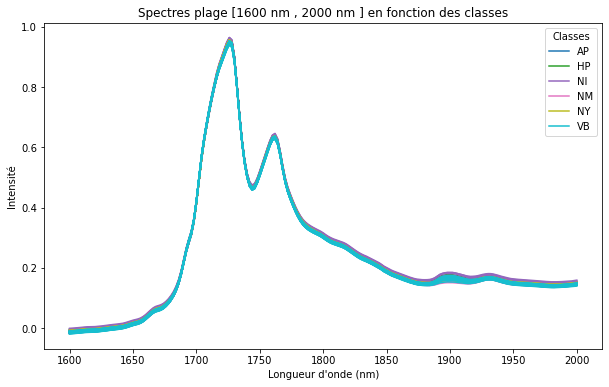

In [112]:

# Créer un dictionnaire pour mapper les couleurs aux labels
unique_labels = np.unique(classe)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Utiliser la colormap 'tab10'

# Tracer les spectres avec les couleurs basées sur les labels
plt.figure(figsize=(10, 6))
for i in range(len(classe)):
    label = classe[i]
    color = color_map(unique_labels.tolist().index(label))  # Associer la couleur basée sur l'index du label unique
    plt.plot(filtered_wavelength , filtered_intensities[i], label=label, color=color)

plt.xlabel('Longueur d\'onde (nm)')
plt.ylabel('Intensité')
plt.title('Spectres plage [1600 nm , 2000 nm ] en fonction des classes')

# Créer une légende avec des couleurs basées sur les labels uniques
handles = [plt.Line2D([0], [0], color=color_map(i), label=label) for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title='Classes', loc='upper right')

# Afficher le graphique
plt.show()


# 3- Prétraitement des spectres et ACP.

Appliquez un prétraitement SNV, puis effectuer une ACP centrée non réduite des spectres transformées.

## Prétraitement SNV

In [113]:
# Appliquer la transformation SNV à chaque spectre dans le tableau
snv_spectra = np.apply_along_axis(snv_spectrum, axis=1, arr=filtered_intensities)
len(snv_spectra)

187

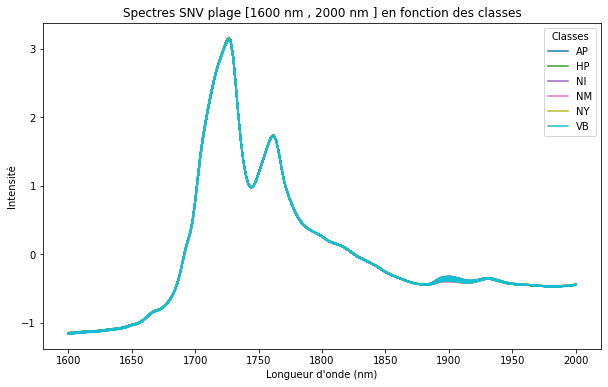

In [114]:

# Créer un dictionnaire pour mapper les couleurs aux labels
unique_labels = np.unique(classe)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Utiliser la colormap 'tab10'

# Tracer les spectres avec les couleurs basées sur les labels
plt.figure(figsize=(10, 6))
for i in range(len(classe)):
    label = classe[i]
    color = color_map(unique_labels.tolist().index(label))  # Associer la couleur basée sur l'index du label unique
    plt.plot(filtered_wavelength , snv_spectra[i], label=label, color=color)

plt.xlabel('Longueur d\'onde (nm)')
plt.ylabel('Intensité')
plt.title('Spectres SNV plage [1600 nm , 2000 nm ] en fonction des classes')

# Créer une légende avec des couleurs basées sur les labels uniques
handles = [plt.Line2D([0], [0], color=color_map(i), label=label) for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title='Classes', loc='upper right')

# Afficher le graphique
plt.show()


## ACP

In [115]:
pca = PCA( 10)
X = snv_spectra
X_mean = np.mean(X)
X_centered = X- X_mean
pca = pca.fit(X_centered)
explained_variance = pca.explained_variance_ratio_ ## variance expliqué par l'ACP
score = pca.transform(X_centered)
score

array([[-1.06122961e-02, -9.56630104e-03, -1.49361942e-02, ...,
         6.60026480e-03, -5.01221606e-03,  6.01150636e-04],
       [ 6.86285868e-03,  3.14894928e-02, -2.79985282e-02, ...,
         2.32116625e-03,  2.37557554e-04, -1.07080157e-03],
       [-7.44505729e-03,  2.99891341e-02, -2.44634531e-02, ...,
         7.18855850e-03, -4.83742610e-04, -7.92345538e-04],
       ...,
       [ 7.00987533e-02,  1.06467338e-01,  6.71858509e-03, ...,
        -6.11313686e-03,  3.83810535e-04, -1.10335249e-03],
       [ 4.94181108e-02,  8.56940102e-02, -2.64562380e-03, ...,
         2.00993791e-03, -2.95724549e-03,  6.15357396e-03],
       [ 2.20351045e-02,  9.13464947e-02,  7.07482705e-03, ...,
         3.22879223e-04, -3.08645968e-05, -4.04052014e-03]])

### diagramme de variance expliquée de l'ACP 

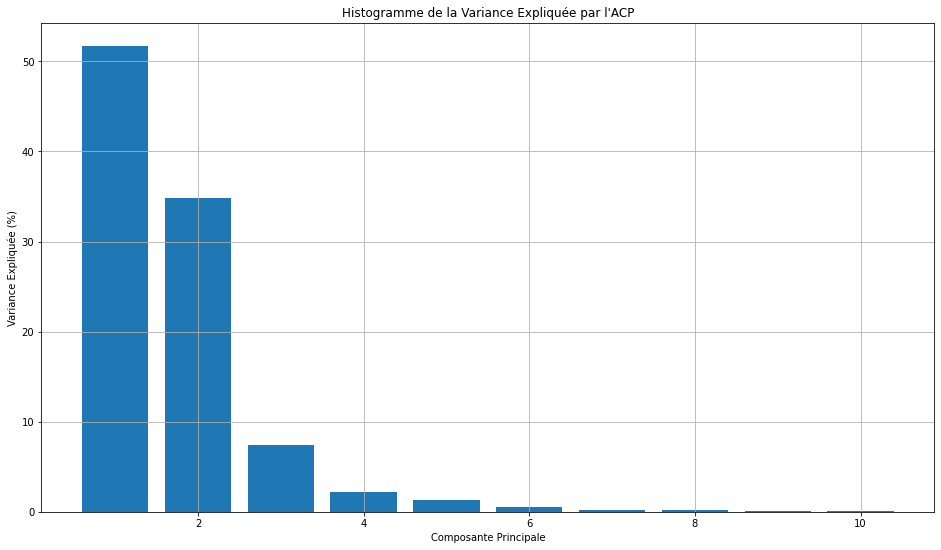

In [116]:
### visualisation de la variance expliquée par l'ACP
plt.figure(figsize=(16,9))
plt.bar(range(1, len(explained_variance) + 1), explained_variance*100, align='center')
plt.title('Histogramme de la Variance Expliquée par l\'ACP')
plt.xlabel('Composante Principale')
plt.ylabel('Variance Expliquée (%)')
plt.grid(True)
plt.show()

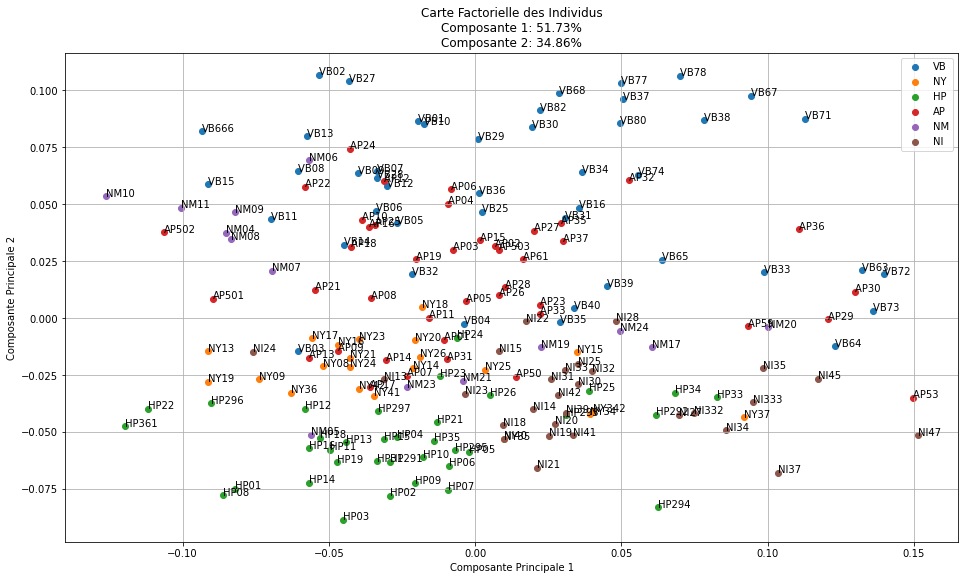

In [117]:
plot_acp_individuals(score=score, plan_indices=(0,1), individual_names=noms_individus, class_labels= classe , explained_variance = explained_variance )

# 4- Classification non supervisée.
Faites une classification hi ́erarchique des spectres SNV avec la m ́ethode Ward, et representez l’arbre hi ́erarchique r ́esultant. Coupez l’arbre hi ́erarchique en 6 groupes, calculez les spectres moyens de ces classes et repr ́esentez-les.

### classification hiérachique des spectres SNV avec la méthode ward

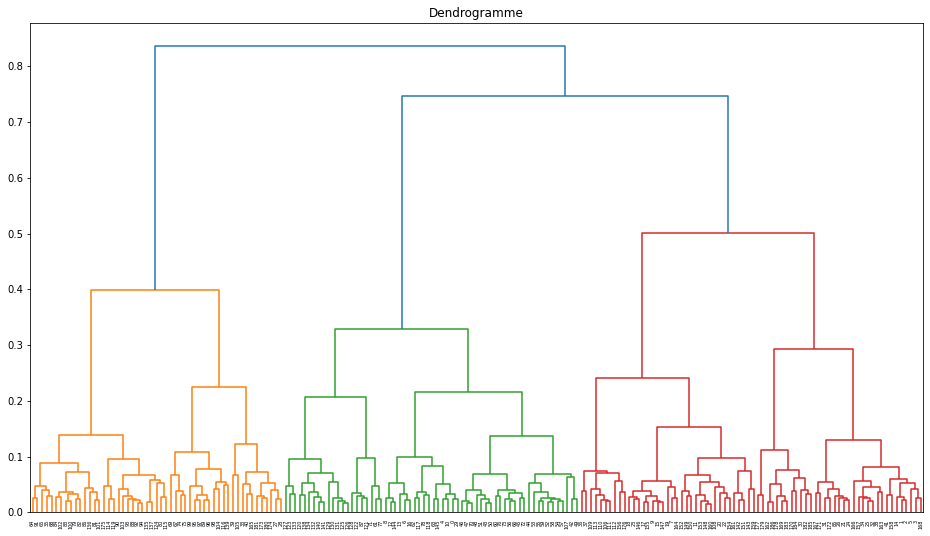

Cluster 1 indices: [1, 2, 3, 5, 14, 21, 24, 25, 26, 30, 31, 32, 34, 38, 41, 85, 157, 158, 162, 163, 166, 167, 168, 169, 170, 171, 172, 177, 178, 179, 182, 183, 184, 185, 186]
Cluster 2 indices: [7, 9, 11, 15, 17, 18, 19, 20, 22, 23, 36, 37, 106, 108, 109, 110, 111, 112, 113, 142, 143, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 159, 160, 161, 164, 176]
Cluster 3 indices: [27, 28, 33, 39, 40, 67, 69, 74, 75, 89, 95, 96, 97, 98, 99, 104, 105, 116, 139, 165, 173, 174, 180, 181]
Cluster 4 indices: [0, 4, 6, 8, 10, 12, 13, 16, 29, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 66, 70, 72, 73, 76, 78, 107, 117, 118, 144, 145]
Cluster 5 indices: [35, 64, 65, 68, 79, 80, 81, 82, 83, 84, 86, 88, 90, 91, 92, 93, 94, 100, 101, 102, 103, 114, 115, 119, 124, 135, 136, 137, 175]
Cluster 6 indices: [61, 71, 77, 87, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 138, 140, 141]


In [118]:
# initialisation pour avoir toujours les même resultats
np.random.seed(0) # on fixe la graine aléatoire
# Créer une instance du modèle de clustering hiérarchique
n_clusters = 6  # Nombre de clusters souhaité
hca= AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

# Ajuster le modèle aux données
cluster_labels = hca.fit_predict(X)

# Créer la matrice de liaison (dendrogramme)
Z = linkage(X, method='ward')

# Afficher le dendrogramme
plt.figure(figsize=(16, 9))
plt.title('Dendrogramme')
dendrogram(Z)
plt.show()

# Afficher les indices des individus pour chaque cluster
cluster_indices = [[] for _ in range(n_clusters)]

for i, label in enumerate(cluster_labels):
    cluster_indices[label].append(i)

# Afficher les indices des individus pour chaque cluster
for i, indices in enumerate(cluster_indices):
    print(f"Cluster {i+1} indices:", indices)



In [119]:
### calculons les spectres moyens et representonts les
spectres_moyen_hca = []
classe_spectres_moyen=[]
for i in range(len(cluster_indices)):
    spectres_moyen_hca.append(np.mean(X[cluster_indices[i]],axis=0))

for i in range(len(spectres_moyen_hca)):
    classe_spectres_moyen.append(f"spectres moyen Cluster {i+1}")



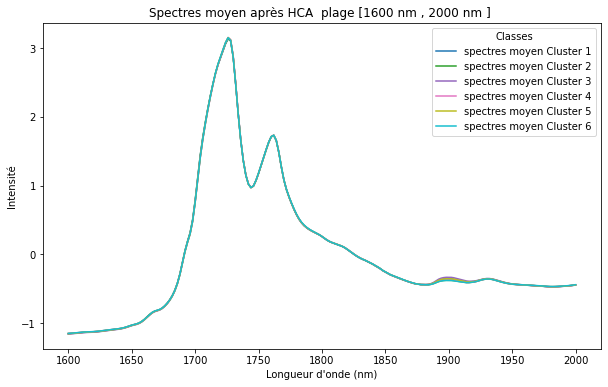

In [120]:
### visualisons les spectres moyens 
# Créer un dictionnaire pour mapper les couleurs aux labels
unique_labels = np.unique(classe_spectres_moyen)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Utiliser la colormap 'tab10'

# Tracer les spectres avec les couleurs basées sur les labels
plt.figure(figsize=(10, 6))
for i in range(len(classe_spectres_moyen)):
    label = classe_spectres_moyen[i]
    color = color_map(unique_labels.tolist().index(label))  # Associer la couleur basée sur l'index du label unique
    plt.plot(filtered_wavelength , spectres_moyen_hca[i], label=label, color=color)

plt.xlabel('Longueur d\'onde (nm)')
plt.ylabel('Intensité')
plt.title('Spectres moyen après HCA  plage [1600 nm , 2000 nm ] ')

# Créer une légende avec des couleurs basées sur les labels uniques
handles = [plt.Line2D([0], [0], color=color_map(i), label=label) for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title='Classes', loc='upper right')

# Afficher le graphique
plt.show()

In [121]:
labs_spectres_moyen=[]
classe_spectres_moyen =[]
for i in range(len(spectres_moyen_hca)):
    classe_spectres_moyen.append("spectres moyen Cluster")
for i in range(len(spectres_moyen_hca)):
    labs_spectres_moyen.append(f"spectres moyen Cluster {i+1}")
#### trouver les coordonnées des spectres moyens dans l'ACP
classe_hca = np.append(classe,classe_spectres_moyen)
noms_individus_hca = np.append(noms_individus,labs_spectres_moyen)
cord_spectres_moyen_hca = pca.transform(spectres_moyen_hca)
score_cord_hca =np.append( score,cord_spectres_moyen_hca)

### plot


In [122]:
score_cord_hca

array([-0.0106123 , -0.0095663 , -0.01493619, ...,  0.00139426,
        0.00012062, -0.00079022])

In [123]:
classe

array(['AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP',
       'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP',
       'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP',
       'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'HP', 'HP',
       'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP',
       'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP',
       'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP',
       'HP', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI',
       'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI',
       'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NM', 'NM', 'NM', 'NM',
       'NM', 'NM', 'NM', 'NM', 'NM', 'NM', 'NM', 'NM', 'NM', 'NM', 'NY',
       'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY',
       'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'VB',
       'VB', 'VB', 'VB', 'VB', 'VB', 'VB', 'VB', 'V

In [124]:
classe_hca 

array(['AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP',
       'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP',
       'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP',
       'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'HP', 'HP',
       'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP',
       'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP',
       'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP', 'HP',
       'HP', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI',
       'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI',
       'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NI', 'NM', 'NM', 'NM', 'NM',
       'NM', 'NM', 'NM', 'NM', 'NM', 'NM', 'NM', 'NM', 'NM', 'NM', 'NY',
       'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY',
       'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'NY', 'VB',
       'VB', 'VB', 'VB', 'VB', 'VB', 'VB', 'VB', 'V

In [128]:
score

array([[-1.06122961e-02, -9.56630104e-03, -1.49361942e-02, ...,
         6.60026480e-03, -5.01221606e-03,  6.01150636e-04],
       [ 6.86285868e-03,  3.14894928e-02, -2.79985282e-02, ...,
         2.32116625e-03,  2.37557554e-04, -1.07080157e-03],
       [-7.44505729e-03,  2.99891341e-02, -2.44634531e-02, ...,
         7.18855850e-03, -4.83742610e-04, -7.92345538e-04],
       ...,
       [ 7.00987533e-02,  1.06467338e-01,  6.71858509e-03, ...,
        -6.11313686e-03,  3.83810535e-04, -1.10335249e-03],
       [ 4.94181108e-02,  8.56940102e-02, -2.64562380e-03, ...,
         2.00993791e-03, -2.95724549e-03,  6.15357396e-03],
       [ 2.20351045e-02,  9.13464947e-02,  7.07482705e-03, ...,
         3.22879223e-04, -3.08645968e-05, -4.04052014e-03]])

In [127]:
cord_spectres_moyen_hca 

array([[ 3.04404733e-02,  4.96538685e-02, -6.36724414e-03,
         1.12373117e-03, -1.72884841e-03,  3.74917908e-04,
        -5.68931656e-04, -2.72881479e-04, -2.90458482e-04,
         3.64884909e-05],
       [-5.30747975e-02,  5.21566866e-02, -2.81540184e-03,
         3.90417167e-04,  1.45321631e-04, -1.58328728e-03,
         4.00360551e-04, -5.10687781e-04,  2.23868153e-04,
         8.51980374e-05],
       [ 1.04024087e-01, -2.15538498e-02, -1.60559598e-03,
        -4.33381321e-06,  8.81286096e-04,  3.76523096e-04,
         3.53467915e-04,  3.12568693e-04, -4.35273568e-04,
        -4.51767046e-04],
       [-3.13549184e-02, -4.37390169e-02, -1.92014625e-02,
         5.60784539e-04,  1.78626038e-03,  8.95567564e-04,
         2.80658333e-04,  4.49646112e-04,  3.03117217e-04,
         1.64907301e-04],
       [ 2.87906597e-02, -3.08074581e-02,  1.50590412e-02,
        -3.23646089e-03, -9.68414583e-04, -3.23787518e-03,
         3.39412277e-04, -9.23113163e-04, -9.07386122e-05,
         5.